<a href="https://colab.research.google.com/github/Balaji-0-5/N-Body-Simulation/blob/main/Brute_force.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#TODO 
#Write clean documentation for everything

In [ ]:
from google.colab import files

In [ ]:
#imports
import numpy as np
import numba as nb
import json
print("numpy :",np.__version__)
print("numba :",nb.__version__)
print("json :",json.__version__) 

numpy : 1.22.4
numba : 0.56.4
json : 2.0.9


In [ ]:
np.random.seed(123)

In [ ]:
# Define constants (in units of kpc, Msun, and Myr)
G = 4.498768e-6 # kpc^3 / (Msun Myr^2)
R0 = 8.0 # kpc (distance from Sun to Galactic center)
M_bulge = 5e2 # Msun
M_disk = 3e3 # Msun
M_halo = 2e4 # Msun
R_bulge = 0.2 # kpc (scale radius of bulge)
R_disk = 0.7 # kpc (scale length of disk)
R_halo = 3.0 # kpc (scale radius of halo)
z0_disk = 0.05 # kpc (scale height of disk)
z0_bulge = 0.02 # kpc (scale height of bulge)

# Generate particle positions
N_bulge = 1000
N_disk = 10000
N_halo = 9000
N_tot = N_bulge + N_disk + N_halo

# Generate positions and momenta for the bulge particles
X_bulge = np.random.normal(scale=R_bulge, size=N_bulge)
Y_bulge = np.random.normal(scale=R_bulge, size=N_bulge)
Z_bulge = np.random.normal(scale=z0_bulge, size=N_bulge)
R_bulge = np.sqrt(X_bulge**2 + Y_bulge**2 + Z_bulge**2)
M_bulge_particle = M_bulge/N_bulge
P_bulge = np.sqrt(2*M_bulge_particle*G*R_bulge**2/R_bulge)*(np.random.normal(size=N_bulge))
Px_bulge = -P_bulge*X_bulge/R_bulge
Py_bulge = -P_bulge*Y_bulge/R_bulge
Pz_bulge = -P_bulge*Z_bulge/R_bulge

# Generate positions and momenta for the disk particles
R_disk = np.random.exponential(scale=R_disk, size=N_disk)
phi_disk = np.random.uniform(0, 2*np.pi, size=N_disk)
X_disk = R_disk*np.cos(phi_disk)
Y_disk = R_disk*np.sin(phi_disk)
Z_disk = np.random.normal(scale=z0_disk, size=N_disk)
M_disk_particle = M_disk/N_disk
P_disk = np.sqrt(2*M_disk_particle*G*R_disk)*np.sqrt(R0/R_disk)*(1 + np.random.normal(scale=0.1, size=N_disk))
Px_disk = -P_disk*np.sin(phi_disk)
Py_disk = P_disk*np.cos(phi_disk)
Pz_disk = np.zeros(N_disk)

# Generate positions and momenta for the halo particles
R_halo = np.random.exponential(scale=R_halo, size=N_halo)
phi_halo = np.random.uniform(0, 2*np.pi, size=N_halo)
theta_halo = np.arccos(2*np.random.uniform(size=N_halo) - 1)
X_halo = R_halo*np.sin(theta_halo)*np.cos(phi_halo)
Y_halo = R_halo*np.sin(theta_halo)*np.sin(phi_halo)
Z_halo = R_halo*np.cos(theta_halo)
M_halo_particle = M_halo/N_halo
P_halo = np.sqrt(2*M_halo_particle*G*R_halo)

In [ ]:
# Particle masses
Masses = np.concatenate((np.full(N_bulge, M_bulge_particle),
                         np.full(N_disk, M_disk_particle),
                         np.full(N_halo, M_halo_particle)))

# Particle positions
X = np.concatenate((X_bulge, X_disk, X_halo))
Y = np.concatenate((Y_bulge, Y_disk, Y_halo))
Z = np.concatenate((Z_bulge, Z_disk, Z_halo))
pos = np.array((X, Y, Z))

# Particle momenta
PX = np.concatenate((Px_bulge*M_bulge_particle, Px_disk*M_disk_particle, P_halo*M_halo_particle))
PY = np.concatenate((Py_bulge*M_bulge_particle, Py_disk*M_disk_particle, P_halo*M_halo_particle))
PZ = np.concatenate((Pz_bulge*M_bulge_particle, Pz_disk*M_disk_particle, P_halo*M_halo_particle))
mom = np.array((PX, PY, PZ))

dt = 0.2

In [ ]:
# Define the function to be accelerated
@nb.njit(parallel=True,fastmath=True)
def force_array(pos_arr, m_array, G, epsilon):
    n = pos_arr.shape[1]
    force_arr = np.zeros((3, n, n))
    for i in nb.prange(n):
        for j in nb.prange(i):
            r = np.linalg.norm(pos_arr[:, i] - pos_arr[:, j])
            softening_term = (r ** 2 + epsilon ** 2) ** (3/2)
            force = G * m_array[i] * m_array[j] * (pos_arr[:, j] - pos_arr[:, i]) / softening_term
            force_arr[:, i, j] = force
            force_arr[:, j, i] = -force
    return force_arr


@nb.njit(parallel=True,fastmath=True)
def update_momentum(step, mom_arr, force_arr):
    n = mom_arr.shape[1]
    del_mom = np.zeros_like(mom_arr)
    for i in nb.prange(n):
        for j in nb.prange(n):
            if i != j:
                del_mom[:, i] += step * force_arr[:, i, j]
    return mom_arr + del_mom

@nb.njit(parallel=True,fastmath=True)
def update_position(step, pos_arr, new_mom, m_arr):
    n = pos_arr.shape[1]
    for i in nb.prange(n):
        pos_arr[:, i] += step * new_mom[:, i] / m_arr[i]
    return pos_arr 

@nb.njit(parallel=True,fastmath=True)
def Run_sim(N_steps, pos_arr, mom_arr, mass_arr, start=0, dt=1.e-2, G=6.67408e-11,epsilon=0.01):
    pos_data = np.zeros((3, len(pos_arr.transpose()),N_steps))
    for i in range(start, N_steps):
        force = force_array(pos_arr, mass_arr, G,epsilon)
        mom_arr = update_momentum(dt, mom_arr, force)
        pos_arr = update_position(dt, pos_arr, mom_arr, mass_arr)
        pos_data[:, :, i] = pos_arr
    
    return pos_arr, mom_arr, pos_data

def save_data(pos_arr,mom_arr,pos_data,N_steps,dt,Run):
    data = {"N_steps":N_steps,
            "sim_time":dt*N_steps,
            "sim_data_shape":pos_data.shape,
            "pos_data":pos_arr.tolist(),
            "mom_data":mom_arr.tolist(),
            "sim_data":pos_data.tolist()}
    with open("Run_"+str(Run)+".json", "w") as f:
        json.dump(data, f, indent=4)

    files.download("Run_"+str(Run)+".json")


In [ ]:
N_steps = 50

In [ ]:
Run = "00001"

In [ ]:
First_run = Run_sim(N_steps,pos,mom,Masses,dt=dt,G=G)

pos_arr,mom_arr,pos_data = First_run

save_data(pos_arr,mom_arr,pos_data,N_steps,dt,Run)

print("Run Successful")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Run Successful


In [ ]:
Run = "00002"

In [ ]:
Second_run = Run_sim(N_steps,pos_arr,mom_arr,Masses,dt=dt,G=G)

pos_arr,mom_arr,pos_data = Second_run

save_data(pos_arr,mom_arr,pos_data,N_steps,dt,Run)

print("Run Successful")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Run Successful


In [ ]:
Run = "00003"

In [ ]:
third_run = Run_sim(N_steps,pos_arr,mom_arr,Masses,dt=dt,G=G)

pos_arr,mom_arr,pos_data = third_run

save_data(pos_arr,mom_arr,pos_data,N_steps,dt,Run)

print("Run Successful")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Run Successful


In [ ]:
Run = "00004"

In [ ]:
fourth_run = Run_sim(N_steps,pos_arr,mom_arr,Masses,dt=dt,G=G)

pos_arr,mom_arr,pos_data = fourth_run

save_data(pos_arr,mom_arr,pos_data,N_steps,dt,Run)

print("Run Successful")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Run Successful


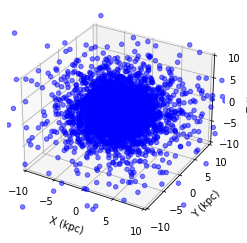

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot bulge particles
ax.scatter(X_bulge, Y_bulge, Z_bulge, c='r', alpha=0.5)

# Plot disk particles
ax.scatter(X_disk, Y_disk, Z_disk, c='g', alpha=0.5)

# Plot halo particles
ax.scatter(X_halo, Y_halo, Z_halo, c='b', alpha=0.5)

# Set axis labels
ax.set_xlabel('X (kpc)')
ax.set_ylabel('Y (kpc)')
ax.set_zlabel('Z (kpc)')

# Set axis limits
ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)
ax.set_zlim(-10, 10)

# Save the figure
plt.savefig("initial_config.png")

# Show the figure
plt.show()


#Benchmarking

take 23min for 10000particles with 100steps and take 4gbram .

45 s   all for 1k particles

46 s

20 s

only njit --> 36.2 s ± 603 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

njit(fastmath=True) --> 35.8 s ± 267 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

njit(parallel=True) --> 11 s ± 95.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

12 min for 20k particles with 10 time steps

1min 16s ± 4.37 s per loop (mean ± std. dev. of 7 runs, 1 loop each)  --> for 20k particles

3min 40s ± 2.58 s per loop (mean ± std. dev. of 7 runs, 1 loop each)  --> 21k particles with galactic parameters

In [ ]:
%timeit Run_sim(1,pos,mom,Masses,G=G)